In [1]:
write = False # log this version as new
MODEL_DESCRIPTION = "Increase KL weight"

In [2]:
import os
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sys import stdout
from datetime import datetime
import neptune.new as neptune
from neptune.new.integrations.tensorflow_keras import NeptuneCallback

In [3]:
from tensorflow.keras.models import Model
from keras import backend as K
from tensorflow.keras.layers import Cropping2D, ZeroPadding2D, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape
import tensorflow_probability as tfp
from tensorflow_probability import layers as tfpl
from tensorflow_probability import distributions as tfd
from tensorflow.nn import leaky_relu
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

In [4]:
LATENT_DIM = 128
BASE_DEPTH = 8
IMAGE_SHAPE = (5, 127, 127)
EPOCHS = 200
CHECKPOINTS_TO_SAVE = 4
KL_WEIGHT = 0
# Good value: 1e-6

In [5]:
gpus = tf.config.list_physical_devices('GPU');
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 20000)]);
        logical_gpus = tf.config.experimental.list_logical_devices('GPU');
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [6]:
now = datetime.now()

DATASET_NAME = "HSC_v6_small"
MODEL_TYPE = "VAE"
MODEL_VERSION = "v1.0"
MODEL_SUBVERSION = "v1.0." + now.strftime("%Y%m%d_%H_%M_%S")

model_id = '_'.join([DATASET_NAME, MODEL_TYPE, MODEL_VERSION])
model_path = os.path.join('/models', model_id, MODEL_SUBVERSION, 'model')
checkpoints_path = os.path.join('/models', model_id, MODEL_SUBVERSION, 'checkpoints')
logs_path = os.path.join('/logs', model_id, MODEL_SUBVERSION)
predictions_path = os.path.join('/predictions', model_id, MODEL_SUBVERSION)
weights_path = model_path + '/weights.h5'

os.makedirs(model_path, exist_ok = True)
os.makedirs(checkpoints_path, exist_ok = True)
os.makedirs(logs_path, exist_ok = True)
os.makedirs(predictions_path, exist_ok = True)

if write == True:
    with open("/models/README.md", "a") as myfile:
        myfile.write(MODEL_TYPE + " " + MODEL_SUBVERSION + " - " + MODEL_DESCRIPTION + " - B. Li" + "\n")
else:
    with open("/models/README.md", "a") as myfile:
        myfile.write(MODEL_TYPE + " " + MODEL_SUBVERSION + " - ... "+ " - B. Li" + "\n")

In [7]:
hf_train = h5py.File('/data/HSC/HSC_v6/step2A/127x127/5x127x127_training_small.hdf5', 'r')
hf_test = h5py.File('/data/HSC/HSC_v6/step2A/127x127/5x127x127_testing_small.hdf5', 'r')
hf_validation = h5py.File('/data/HSC/HSC_v6/step2A/127x127/5x127x127_validation_small.hdf5', 'r')
x_train = np.asarray(hf_train['image'][0:])
x_test = np.asarray(hf_test['image'][0:])
x_validation = np.asarray(hf_validation['image'][0:])
max_value = 4.16
x_train = np.true_divide(x_train, max_value)
x_test = np.true_divide(x_test, max_value)
x_validation = np.true_divide(x_validation, max_value)
y_train = np.asarray(hf_train['specz_redshift'][0:])
y_test = np.asarray(hf_test['specz_redshift'][0:])
y_validation = np.asarray(hf_validation['specz_redshift'][0:])
# object_id_train = np.asarray(hf_train['object_id'][0:])
# object_id = np.asarray(hf_test['object_id'][0:])
# object_id_validation = np.asarray(hf_validation['object_id'][0:])
hf_train.close()
hf_test.close()
hf_validation.close()

In [8]:
def sample_z(args):
    mu, l_sigma = args
    eps = K.random_normal(shape = (len(x_train), LATENT_DIM), mean = 0, stddev = 0.1)
    return mu + K.exp(l_sigma / 2) * eps

In [9]:
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(LATENT_DIM), scale = 0.1), reinterpreted_batch_ndims = 1)

images = Input(shape = IMAGE_SHAPE)
redshifts = Input(shape = 1,)
conv1 = Conv2D(BASE_DEPTH, 3, strides = 2, activation = leaky_relu,
            padding = 'same', data_format = 'channels_first')(images)
conv2 = Conv2D(BASE_DEPTH, 3, strides = 2, activation = leaky_relu,
            padding = 'same', data_format = 'channels_first')(conv1)
flatten = Flatten()(conv2)
dense1 = Dense(4096, activation = None)(flatten)
dense2 = tf.keras.layers.Dense(32, activation = "relu")(redshifts)
dense3 = tf.keras.layers.Dense(32, activation = "relu")(dense2)
concat = tf.keras.layers.Concatenate()([dense1, dense3])
dense4 = Dense(tfpl.MultivariateNormalTriL.params_size(LATENT_DIM), activation = None)(concat)
z = tfpl.MultivariateNormalTriL(LATENT_DIM,
            activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight = KL_WEIGHT))(dense4)
encoder = Model([images, redshifts], z)

zc = tf.keras.layers.Concatenate()([z, redshifts])

dense5 = Dense(8 * LATENT_DIM * 32 * 32, activation = None)(zc)
reshape = Reshape((8 * LATENT_DIM, 32, 32))(dense5)
conv3 = Conv2DTranspose(BASE_DEPTH, 3, strides = 2, activation = leaky_relu,
                    padding = 'same', data_format = 'channels_first')(reshape)
conv4 = Conv2DTranspose(BASE_DEPTH, 3, strides = 2, activation = leaky_relu,
                    padding = 'same', data_format = 'channels_first')(conv3)
conv5 = Conv2DTranspose(BASE_DEPTH, 3, strides = 1, activation = leaky_relu, 
                    padding = 'same', data_format = 'channels_first')(conv4)
conv6 = Conv2D(IMAGE_SHAPE[0], 3, strides = 1, activation = None, 
           padding = 'same', data_format = 'channels_first')(conv5)
cropping = Cropping2D(cropping=((0, 1), (0, 1)), data_format = 'channels_first')(conv6)
outputs = Reshape(IMAGE_SHAPE)(cropping)

In [10]:
model = Model(inputs = [images, redshifts], outputs = [outputs])

In [11]:
latents = Input(shape = (LATENT_DIM + 1, ))
dense5 = Dense(8 * LATENT_DIM * 32 * 32, activation = None)(latents)
reshape = Reshape((8 * LATENT_DIM, 32, 32))(dense5)
conv3 = Conv2DTranspose(BASE_DEPTH, 3, strides = 2, activation = leaky_relu,
                    padding = 'same', data_format = 'channels_first')(reshape)
conv4 = Conv2DTranspose(BASE_DEPTH, 3, strides = 2, activation = leaky_relu,
                    padding = 'same', data_format = 'channels_first')(conv3)
conv5 = Conv2DTranspose(BASE_DEPTH, 3, strides = 1, activation = leaky_relu, 
                    padding = 'same', data_format = 'channels_first')(conv4)
conv6 = Conv2D(IMAGE_SHAPE[0], 3, strides = 1, activation = None, 
           padding = 'same', data_format = 'channels_first')(conv5)
cropping = Cropping2D(cropping=((0, 1), (0, 1)), data_format = 'channels_first')(conv6)
outputs = Reshape(IMAGE_SHAPE)(cropping)

In [12]:
decoder = Model(latents, outputs)

In [13]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5, 127, 127) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 8, 64, 64)    368         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 32, 32)    584         conv2d[0][0]                     
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
____________________________________________________________________________________________

In [14]:
def vae_loss(y_true, y_pred):
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

In [15]:
model.compile(optimizer = 'adam', loss = vae_loss)

In [16]:
run = neptune.init(
    name = MODEL_SUBVERSION,
    project = "astro-data-lab/VAE",
    api_token = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxOGFlZGMxOC04MWU5LTQ2NDctYjlhZS05NGE2NGQ0NmIzMmEifQ==",
)  # your credentials

# logs_callback = TensorBoard(log_dir = logs_path)

weights_callback = ModelCheckpoint(filepath = os.path.join(checkpoints_path, 'weights_epoch{epoch}.hdf5'), save_freq = int(EPOCHS/CHECKPOINTS_TO_SAVE), save_weights_only = True)

LR_callback = ReduceLROnPlateau()

# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs_path, histogram_freq = 1)

neptune_callback = NeptuneCallback(run = run)

https://app.neptune.ai/astro-data-lab/VAE/e/VAE-74
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [17]:
history = model.fit(x = [x_train, y_train], y = x_train, epochs = EPOCHS, callbacks = [weights_callback, LR_callback, neptune_callback], validation_data = ([x_validation, y_validation], x_validation), verbose = 1)

Epoch 1/200
313/313 [==============================] - 453s 123ms/step - loss: 44.4822 - val_loss: 27.7943
Epoch 2/200
313/313 [==============================] - 39s 123ms/step - loss: 24.4088 - val_loss: 14.2254
Epoch 3/200
313/313 [==============================] - 38s 121ms/step - loss: 17.2520 - val_loss: 7.9630
Epoch 4/200
313/313 [==============================] - 43s 136ms/step - loss: 5.7839 - val_loss: 1.1108
Epoch 5/200
313/313 [==============================] - 37s 120ms/step - loss: 4.3040 - val_loss: 1.6793
Epoch 6/200
313/313 [==============================] - 38s 122ms/step - loss: 36.1189 - val_loss: 7.1746
Epoch 7/200
313/313 [==============================] - 37s 119ms/step - loss: 3.9656 - val_loss: 0.4558
Epoch 8/200
313/313 [==============================] - 42s 135ms/step - loss: 3.1049 - val_loss: 2.9116
Epoch 9/200
313/313 [==============================] - 37s 117ms/step - loss: -2.8648 - val_loss: -6.9480
Epoch 10/200
313/313 [==============================] -

313/313 [==============================] - 41s 130ms/step - loss: -16.0870 - val_loss: -14.2170
Epoch 78/200
313/313 [==============================] - 35s 113ms/step - loss: -15.8823 - val_loss: -13.8995
Epoch 79/200
313/313 [==============================] - 36s 115ms/step - loss: -15.0878 - val_loss: -14.0806
Epoch 80/200
313/313 [==============================] - 36s 114ms/step - loss: -15.9859 - val_loss: -14.5512
Epoch 81/200
313/313 [==============================] - 41s 132ms/step - loss: -15.3352 - val_loss: -9.7720
Epoch 82/200
313/313 [==============================] - 36s 116ms/step - loss: -14.8715 - val_loss: -13.6897
Epoch 83/200
313/313 [==============================] - 37s 119ms/step - loss: -15.7237 - val_loss: -14.0469
Epoch 84/200
313/313 [==============================] - 37s 118ms/step - loss: -15.8065 - val_loss: -14.1786
Epoch 85/200
313/313 [==============================] - 43s 136ms/step - loss: -16.2116 - val_loss: -14.1268
Epoch 86/200
313/313 [===========

Epoch 152/200
313/313 [==============================] - 38s 123ms/step - loss: -19.5986 - val_loss: -17.9938
Epoch 153/200
313/313 [==============================] - 39s 124ms/step - loss: -19.7221 - val_loss: -17.7672
Epoch 154/200
313/313 [==============================] - 42s 135ms/step - loss: -19.7169 - val_loss: -17.8031
Epoch 155/200
313/313 [==============================] - 38s 121ms/step - loss: -19.5995 - val_loss: -16.8299
Epoch 156/200
313/313 [==============================] - 38s 121ms/step - loss: -19.5281 - val_loss: -18.0336
Epoch 157/200
313/313 [==============================] - 40s 127ms/step - loss: -19.7441 - val_loss: -17.8962
Epoch 158/200
313/313 [==============================] - 43s 137ms/step - loss: -19.7370 - val_loss: -18.1597
Epoch 159/200
313/313 [==============================] - 37s 117ms/step - loss: -19.7609 - val_loss: -18.1489
Epoch 160/200
313/313 [==============================] - 38s 121ms/step - loss: -19.9638 - val_loss: -18.3586
Epoch 161/

In [20]:
str = np.zeros((1, LATENT_DIM + 1))
str[:, LATENT_DIM] = 1

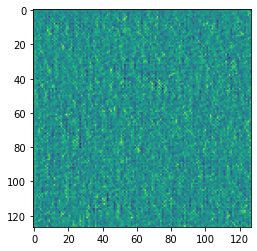

In [21]:
plt.imshow(decoder.predict([str])[0][0])